# Exploratory data analysis.

В данной части я хотел бы показать и подробно обьяснить все преобразования, которые я выполнил перед обучением модели.

### Import libraries.

Для начала импортируем необходимые библиотеки.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

from PIL import Image
from skimage import io
import os
import cv2

import glob
from tqdm import tqdm

### Data distribution.

В нашей задаче имеется 4 класса - стадии болезни (stages of diabetic retinopathy): </br>
0 - Normal </br>
1 - Mild </br>
2 - Moderate </br>
3 - Severe </br>
4 - Proliferative </br>
Посмотрим на распределение предоставленных данных.

In [4]:
labels = pd.read_csv(r"D:\Diabetic Retinopathy\IOGEN_DATASET\dataset\labels.csv", index_col = [0])
labels.head()

level
image             
19840_left       2
32380_right      0
32242_right      2
32610_right      0
27041_right      0

In [3]:
labels.shape

(8000, 1)

In [4]:
def countplot(dataframe, title=None):
    '''
    Функция для построения аннотированных каунтплотов по данным dataframe. 
    Классы datframe должны быть представлены в колонке 'level'.
    title - оптимальный параметр для подписи плота.
    '''
    plt.figure(figsize=(12,6))
    splot = sns.countplot(x = 'level', data = dataframe, palette= "dark:salmon_r");
    maxim_lim = 0

    for g in splot.patches:
        ann_value = g.get_height()
        splot.annotate(format(ann_value, '.0f'),
        (g.get_x() + g.get_width() / 2., g.get_height()),
        ha = 'center', va = 'center',
        xytext = (0, 9),
        textcoords = 'offset points')
        
        if ann_value > maxim_lim:
            maxim_lim = ann_value
    plt.ylim((0, 1.1*maxim_lim))
    plt.title(title)
    return

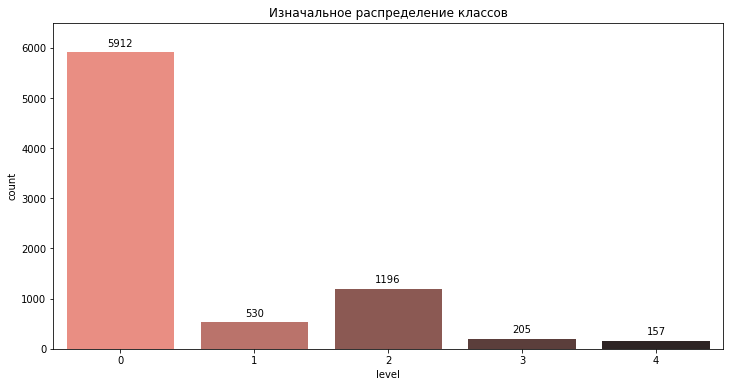

In [5]:
countplot(labels, 'Изначальное распределение классов')

Видим сильный дисбаланс классов. Пожалуй, это одна из главных проблем данной задачи. Посмотрим на процентное соотношение данных по классам.

In [6]:
vc = labels['level'].value_counts().sort_index()
vc / vc.sum() * 100

0    73.9000
1     6.6250
2    14.9500
3     2.5625
4     1.9625
Name: level, dtype: float64

### Garbage

Для интереса мною были просмотрены все картинки из предоставленного датасета. Среди них были найдены "мусорные" картинки. Под ними подразумеваются картинки, которые представляли из себя сплошной цветной фон (в частности черный), обрезанные картинки, слишком зашумленные картинки.

In [7]:
musor = ['3783_right', '10440_left', '15630_right', '31202_right', '33119_left', '36416_right', 
         '44088_left', '26064_left', '766_left', '5869_left', '6523_left', '6523_right', '7647_left',
        '7672_left', '7825_right', '7938_left', '8434_left', '8619_right', '8669_right', '8742_right', 
         '8762_left', '8795_left', '9205_right', '9680_left', '9689_left', '9689_right', 
        '9942_right', '9958_right', '10645_left', '10782_left', '11050_left', '11304_left', '11304_right',
        '11579_right', '11807_left', '11849_right', '12101_right', '12168_left', '12721_left', '12751_left', 
        '13304_left', '13431_right', '13458_left', '13863_right', 
        '14219_left', '14219_right', '14481_right', '15336_left', '15954_left', '16085_right', '16497_left',
        '16890_left', '17734_left', '17770_right', '17800_left', '17989_left', '18171_right', '18257_right',
        '18644_left', '20102_left', '20273_right',  '20428_left', '20670_right', '21225_right', '22026_left',
        '22687_right', '25084_left', '25360_left', '25682_left', '26064_left', '26064_right', 
         '26486_right', '26584_left', '26679_left', '26991_left', '27456_left',  '28288_left', '29139_right',
        '29432_right', '32253_right', '33119_left', '33292_right', '33655_left', '34442_right', '34689_left', '36981_right',
        '37197_right', '37608_left',  '38083_left', '39702_left', '40499_left', '40994_right',
        '41566_left', '41940_right', '42007_left', '43342_right', '43457_left', '43815_right', '43921_left', '44083_right']

# Дабы избежать возможных повторений при ручном просмотре:
musor = np.unique(musor)

Для демонстрации покажем один из интересных примеров (яичница):

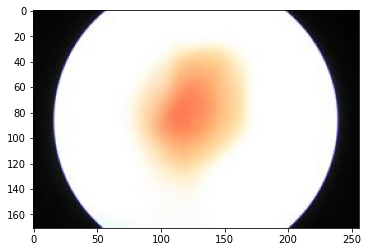

In [8]:
img = io.imread(r"D:\Diabetic Retinopathy\IOGEN_DATASET\musor\10440_left.jpeg")
plt.imshow(img)

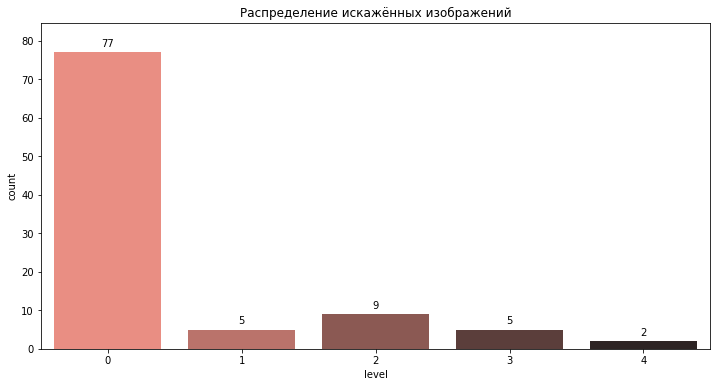

In [9]:
countplot(labels.loc[musor], 'Распределение искажённых изображений')

Сортировка данных не сильно влияет на наше изначальное распределение, но (как выяснилось при изначальном рассмотрении задачки) немного улучшит наши предсказания.

In [10]:
labels = labels.drop(musor)

In [11]:
labels.to_csv('ClearLabels.csv')

### Image transformations.

Посмотрим как выглядят изначальные картинки без обработки.

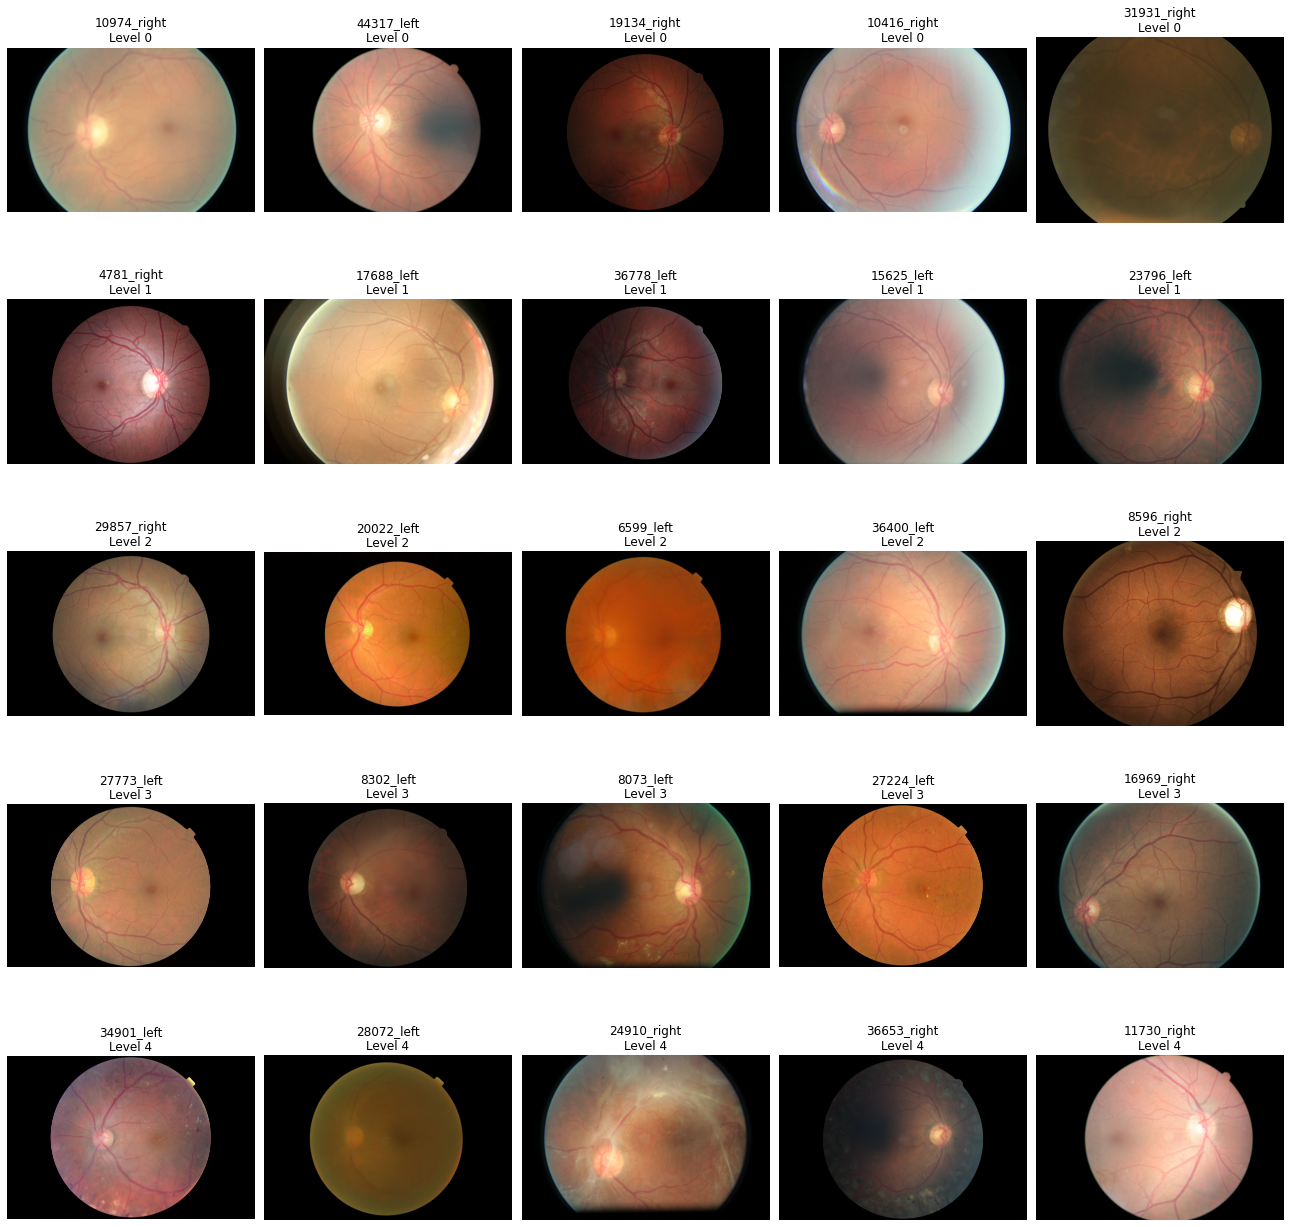

In [251]:
rows, cols = 5, 5
figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(18, 18))
for jj in range(5):
    for i, (idx, row) in enumerate(labels[labels['level']==jj].sample(cols, random_state=42).iterrows()):
        path=r'D:\Diabetic Retinopathy\IOGEN_DATASET\dataset\train\\' + f'{idx}.jpeg'
        ax[jj, i].imshow(io.imread(path))
        ax[jj, i].set_axis_off()
        ax[jj, i].set_title(idx + '\n' + 'Level '+ str(jj))
plt.tight_layout(pad=1)
plt.show()

В первую очередь хочется обрезать черные края у всех картинок и привести к однотипному виду. Для обучения моделей я выбрал расширение 256х256. Поэтому в последующем мы сожмем картинки до указанного размеры. Это позволит нам сэкономить память, а также ускорит работу алгоритмов. Далее мы постараемся нивелировать различное освещение (шум) у картинок, сделав их более серыми. Это один из популярных методов в препроцессинге в данной задаче 
(https://www.kaggle.com/code/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy). При анализе данный ход позволил в целом улучшить предсказания на валидации, поэтому я остановился на нём.

In [5]:
IMG_SIZE = (256, 256)

def crop_image1(img,tol=7):        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
            
        return img

def load_ben_color(path, sigmaX=10):
    image = io.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, IMG_SIZE)
    image = cv2.addWeighted (image, 4, cv2.GaussianBlur( image , (0,0) , sigmaX) , -4 ,128)       
    return image

Посмотрим как выглядят предыдущие картинки после обработки.

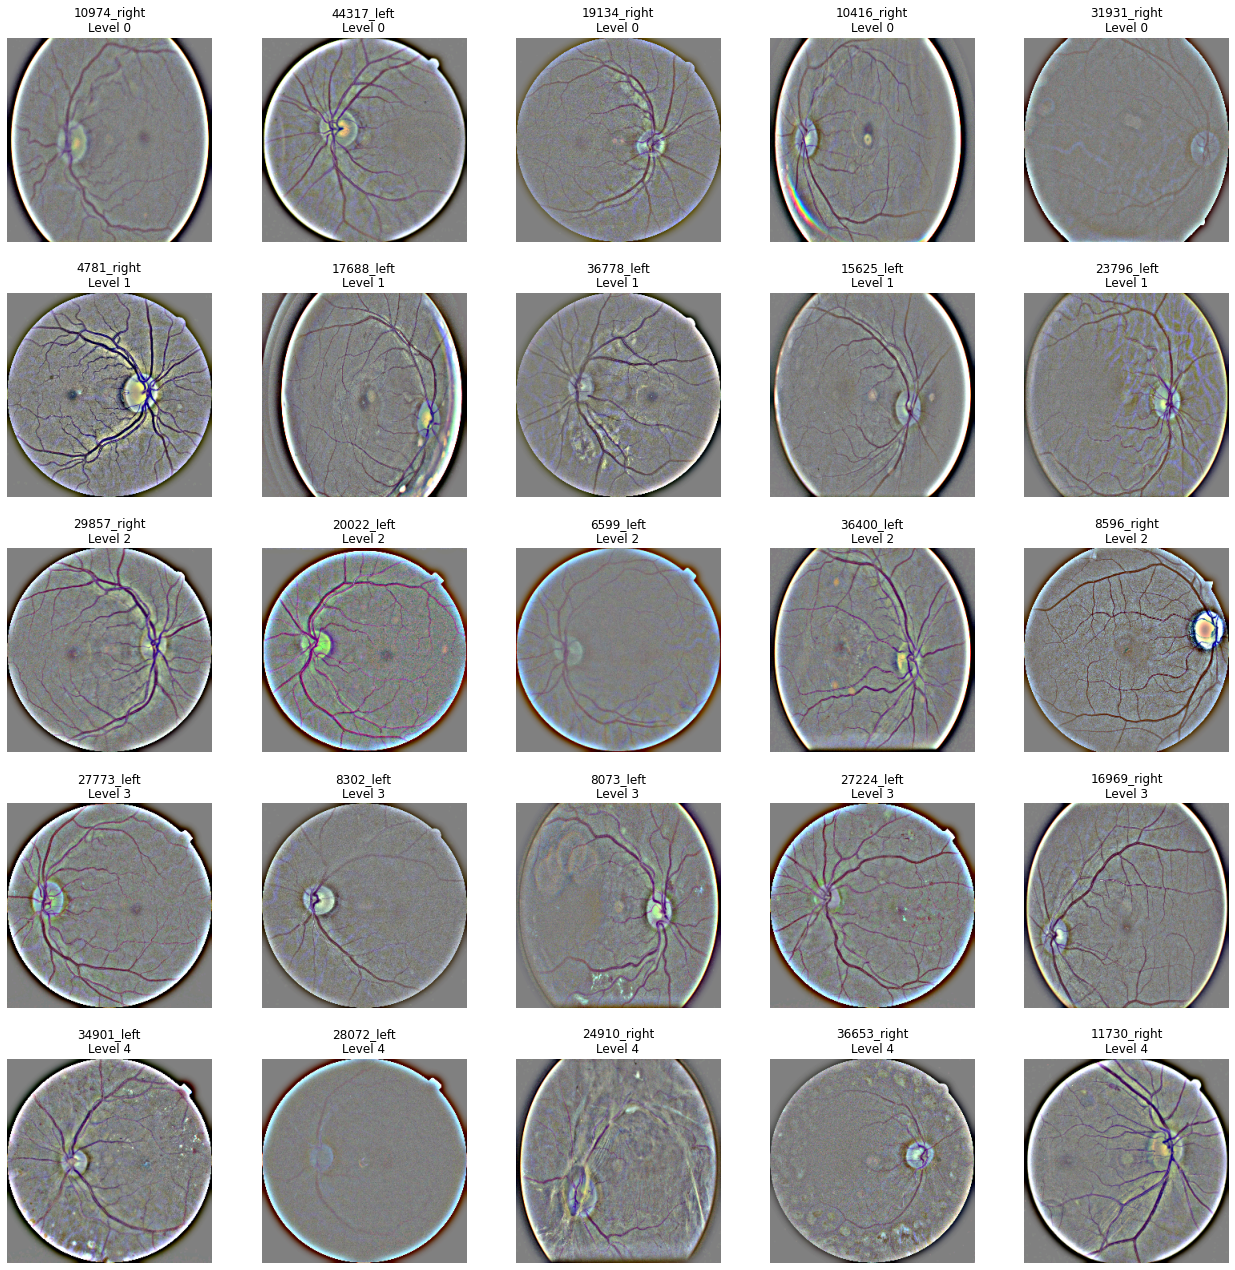

In [256]:
rows, cols = 5, 5
figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(18, 18))
for jj in range(5):
    for i, (idx, row) in enumerate(d[d['level']==jj].sample(cols, random_state=42).iterrows()):
        path=r'D:\Diabetic Retinopathy\IOGEN_DATASET\dataset\train\\' + f'{idx}.jpeg'
        image = load_ben_color(path,sigmaX=5)
        ax[jj, i].imshow(image)
        ax[jj, i].set_axis_off()
        ax[jj, i].set_title(idx + '\n' + 'Level '+ str(jj))
plt.tight_layout(pad=2)
plt.show()

# Saving preprocessed data

In [268]:
save_path = r"D:\Diabetic Retinopathy\IOGEN_DATASET\dataset\train_prep5"
PATHS = []

for file_path in tqdm(glob.glob(r'D:\Diabetic Retinopathy\IOGEN_DATASET\dataset\train\\' + "/*")):
    image = load_ben_color(file_path, sigmaX = 5)
    PATHS.append(file_path)
    name = file_path.split('\\')[-1]
    cv2.imwrite(save_path + '\\' + name, image)

100%|██████████████████████████████████████████████████████████████████████████████| 7902/7902 [28:42<00:00,  4.59it/s]


# Preparing test data

In [7]:
save_path = "D:\Diabetic Retinopathy\INDIAN_DATASET\Original Images\Test_prep5"
for file_path in tqdm(glob.glob(r'D:\Diabetic Retinopathy\INDIAN_DATASET\Original Images\Testing Set' + "/*")):
    image = load_ben_color(file_path, sigmaX = 5)
    name = file_path.split('\\')[-1]
    cv2.imwrite(save_path + '\\' + name, image)

100%|████████████████████████████████████████████████████████████████████████████████| 103/103 [00:26<00:00,  3.90it/s]
